__План исследования (классификация):__ <br>

    1) Загрузить пакетный датасет ирисов. 
  
    2) Провести EDA, включая: 
       - поиск пропусков и проверка типов данных,
       - поиск дубликатов,
       - проверка сбалансированности классов,
       - изучение признаков через графики, 
       - поиск выбросов и их исправление (удаление, замена),
       - отбор признаков (корелляция признаков  между собой) 
       - изучение влияния признаков на цел. переменную
     3) Построение моделей МО - Log. regression, SVC, KMeans


__Загружаем датасет и преобразовывам в датафрейм:__

In [128]:
from sklearn import datasets

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 6)

In [129]:
iris = datasets.load_iris()
data = iris['data']
target = iris['target']

In [130]:
features = iris['feature_names']
features

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [131]:
df = pd.DataFrame(data, columns=features)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
...,...,...,...,...
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3
149,5.9,3.0,5.1,1.8


__EDA:__

In [132]:
# проверяем есть ли пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


В датасете всего 4 признака и пропусков среди них нет. Тип всех значений - рациональные числа.

In [133]:
dup = df[df.duplicated()].shape[0]
print(f"В данном датасете всего строк {df.shape[0]}, среди них выявлено кол-во дубликатов:{dup} шт.")

В данном датасете всего строк 150, среди них выявлено кол-во дубликатов:1 шт.


Посмотрим индексы строк-дублей:

In [134]:
df[df.duplicated(keep=False)]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
101,5.8,2.7,5.1,1.9
142,5.8,2.7,5.1,1.9


Также посмотрим какие номера классов соответствуют этим индексам в переменной target. <br>

Если классы будут разные, то у нас может произойти дезинформация в данных при оставлении "не того" индекса строки , которому реально принадлежит другой класс.<br>
В худшем случае необходимо будет сначала изучить свойства классов и удалять уже с пониманием, что строка, которую будем оставлять в датафрейме реально соотносится с близлежащими точками остальных классов.

In [135]:
target[101], target[142]

(2, 2)

Видим что в обоих случаях один и тот же класс, потому смело удаляем любую из строк.

In [136]:
df.drop_duplicates(keep='first',inplace=True)
# удалена 142 строка

Также важно не забыть удалить и соответствующих элемент индекса в target.

In [137]:
target = np.delete(target, [142])

Проверим сбалансированность данных:

In [138]:
df['target'] = target

df['target'].value_counts()

0    50
1    50
2    49
Name: target, dtype: int64

Как видим, имеем идеально сбалансированный датасет.<br>
Следовательно, в качестве метрики можем использовать accuracy_score и никаких действий для корректировки дисбаланса делать не нужно.

__Ознакомимся с распределением признаков:__

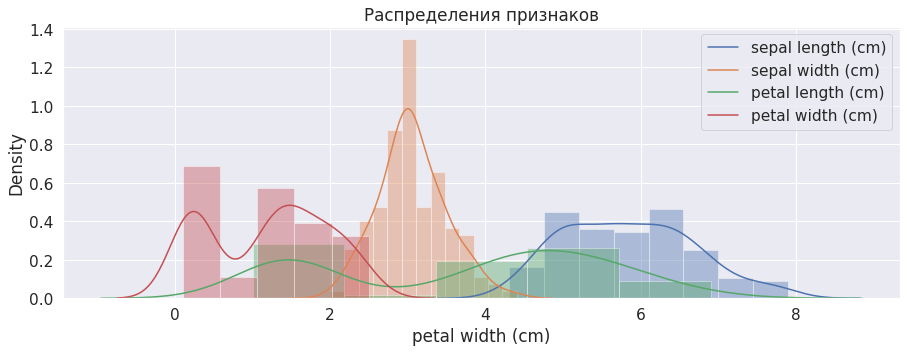

In [139]:
plt.figure(figsize = (15, 5))
plt.title('Распределения признаков')
for i in range(len(features)):
    sns.distplot(df.iloc[:, i])
plt.legend(features)

Посмотрим распределение каждого признака отдельно:


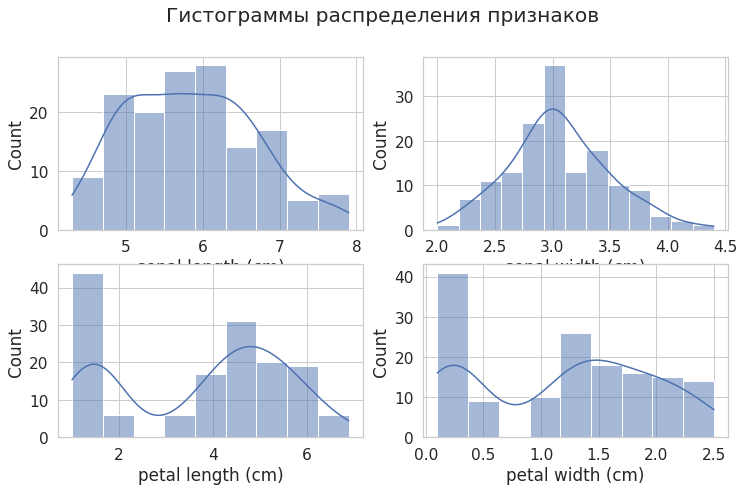

In [140]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
plt.suptitle('Гистограммы распределения признаков')

sns.histplot(ax=ax[0, 0], data=df, x='sepal length (cm)', kde=True)
sns.histplot(ax=ax[0, 1], data=df, x='sepal width (cm)', kde=True)
sns.histplot(ax=ax[1, 0], data=df, x='petal length (cm)', kde=True)
sns.histplot(ax=ax[1, 1], data=df, x='petal width (cm)', kde=True)
plt.show()

Каких-то очевидных выбросов мы здесь не наблюдаем

Посмотрим распределение по классам в с привязкой ко всем признакам:

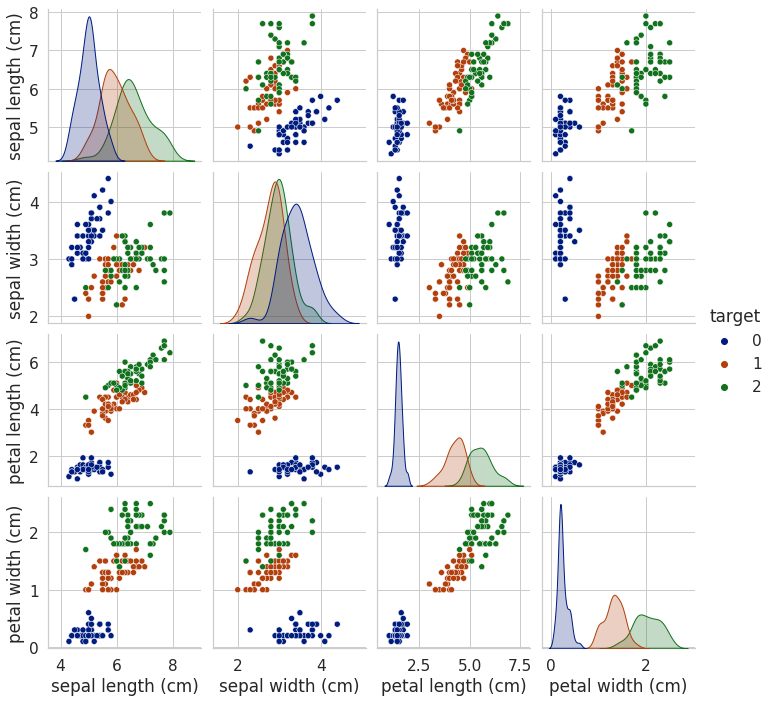

In [141]:
sns.pairplot(df, hue='target', palette='dark')

Посмотрим детальнее распределение классов по признаку petal length:

<AxesSubplot:xlabel='petal length (cm)', ylabel='Density'>

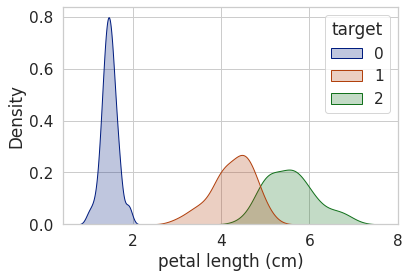

In [142]:
sns.kdeplot(data=df, x=features[2], hue='target', fill=True, palette='dark')

In [143]:
df.loc[df['target']==0].describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,50.00000,50.000000,50.000000,50.000000,50.0
mean,5.00600,3.428000,1.462000,0.246000,0.0
std,0.35249,0.379064,0.173664,0.105386,0.0
...,...,...,...,...,...
50%,5.00000,3.400000,1.500000,0.200000,0.0
75%,5.20000,3.675000,1.575000,0.300000,0.0
max,5.80000,4.400000,1.900000,0.600000,0.0


Из графика видим, что нулевой класс можно опредялять даже без МО, а просто по значениям petal length (cm) меньше 2 cm. <br>

Признаки Petal length и Petal width, судя по тому как на их графике распределены классы, имеют линейную связь.

Ниже проверим эффективность логистической регрессии и метода опорных векторов в решении задачи классификации:

In [144]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :4],target, test_size=0.3, random_state=1)


lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_tr = lr.predict(X_train)
lr_report = classification_report(y_test, y_pred)

print(f"\nClassification Report : \n\n{lr_report}")
print(f' Точность на трейне: {accuracy_score(y_train, y_pred_tr): .4f}, на тесте {accuracy_score(y_test, y_pred): .4f}')


Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      0.94      0.94        16
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45

 Точность на трейне:  0.9712, на тесте  0.9556


In [145]:
clf = SVC(gamma="auto", random_state=1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(f' Точность на трейне: {accuracy_score(y_train, y_pred_train): .4f}, на тесте {accuracy_score(y_test, y_pred): .4f}')

 Точность на трейне:  0.9808, на тесте  0.9778


Теперь нормализуем значения признаков и проверим работу обеих моделей. <br>
Для моделей классификаций масштабирование признаков делается именно через нормализацию (MinMaxScaler)

In [146]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

all_data = df.iloc[:, :4]  # исключаем столбец target, можно было конечно и дропнуть

X = scaler.fit_transform(all_data)

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=1)

In [147]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_tr = lr.predict(X_train)
y_report = classification_report(y_test, y_pred)


print(f' Точность на трейне: {accuracy_score(y_train, y_pred_tr): .2f}, на тесте {accuracy_score(y_test, y_pred): .2f}')

 Точность на трейне:  0.91, на тесте  0.93


In [148]:
clf = SVC(gamma="auto", random_state=1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(f' Точность на трейне: {accuracy_score(y_train, y_pred_train): .4f}, на тесте {accuracy_score(y_test, y_pred):.4f}')

 Точность на трейне:  0.9615, на тесте 0.9556


После нормализации данных качество моделей в обоих случаях стало хуже.<br>
Изучим корелляцию признаков между собой:

<AxesSubplot:>

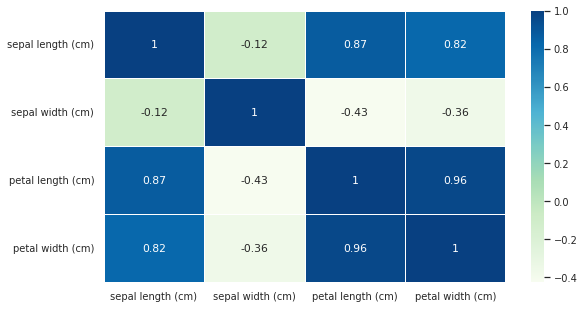

In [149]:
plt.figure(figsize = (9,5))
sns.set(font_scale=0.9)  # font_scale - это параметр размера шрифта строк
sns.heatmap(all_data[all_data.columns.tolist()].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

Помним, что даже самая сильная корелляция сама по себе не может свидетельствовать о причинно-следственной связи; она может быть подтверждена только с помощью постановки эксперимента (обсуждается в главе 18 книги Статистика для всех Сары Бослаф).<br>

ТАКЖЕ прежде чем смотреть корелляцию важно сначала сделать график исследуемой переменной, чтобы убедиться что он будет линейным и проверить нормальное ли распределение.<br>

Поскольку в данном случае модели МО демонстрируют и без того высокий показатель предсказаний, то опустим работу по изучению связей, корелляции и исключению признаков.<br>

__Далее используем метод МО без учителя - KMeans:__

In [150]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X)

# в переменной predictedY запишем алгоритм синхронизации предсканных кластеров имеющимся классам
predictedY = np.choose(kmeans.labels_, [1, 0, 2]).astype(np.int64)

print(f' Точность KMeans: {accuracy_score(target, predictedY): .4f}')

 Точность KMeans:  0.8926


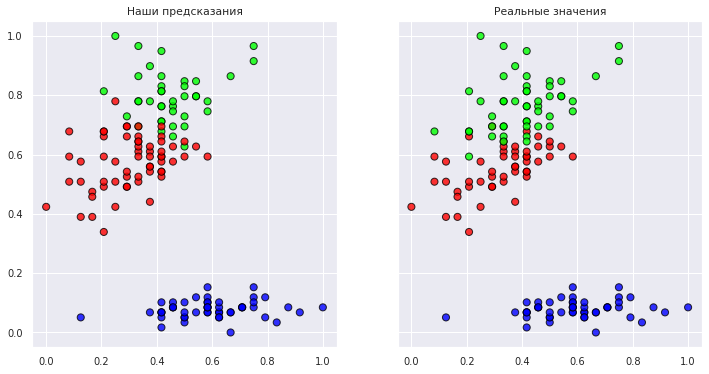

In [151]:
def show_differents(y_test, y_pred, data):

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,6))

    ax1.set_title('Наши предсказания')
    ax1.scatter(data[:, 1], data[:, 2], c=y_pred, s=50, cmap='brg', edgecolors = 'black', alpha = 0.8)
   

    ax2.set_title('Реальные значения')
    ax2.scatter(data[:, 1], data[:, 2], c=y_test, s=50, cmap='brg', edgecolors = 'black', alpha = 0.8);
    
show_differents(target, predictedY, X)

__Ниже пробую сжать данные с помощью TSNE и построить модель на них:__

In [152]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, perplexity=20)  # 1 - 50

X_tsne = tsne.fit_transform(X)

dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_tsne = pd.DataFrame(data=X_tsne, columns=colnames)
components_X_tsne.head()

CPU times: user 7.76 s, sys: 269 ms, total: 8.03 s
Wall time: 3.23 s


,component_1,component_2
0,18.830347,-19.882595
1,16.618647,-25.408348
2,15.905035,-23.597271
3,15.419613,-24.404633
4,18.394360,-19.141272


In [153]:
kmeans2 = KMeans(n_clusters=3, random_state=1)

y_kmeans2 = kmeans2.fit_predict(X_tsne)

predicted_tsne2 = np.choose(kmeans2.labels_, [0, 2, 1]).astype(np.int64)

print(f'Точность KMeans: {accuracy_score(target, predicted_tsne2): .4f}')

Точность KMeans:  0.9597


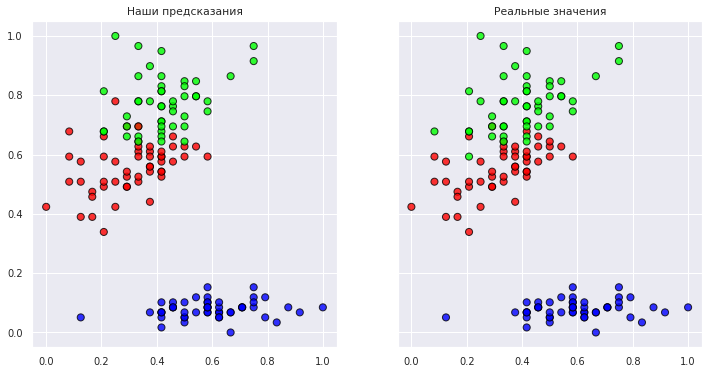

In [154]:
show_differents(target, predicted_tsne2, X)

По итогам исследования были протестированы 3 модели МО, лучшим из них оказался SVC() c рез-том на тесте 0.9556.

Предварительно были исправлены недочеты в данных. Выбросы не были обнаружены на графиках распределения признаков, но сейчас имеет смысл перепроверить это, чтобы поискать возможность еще улучшить качество модели.


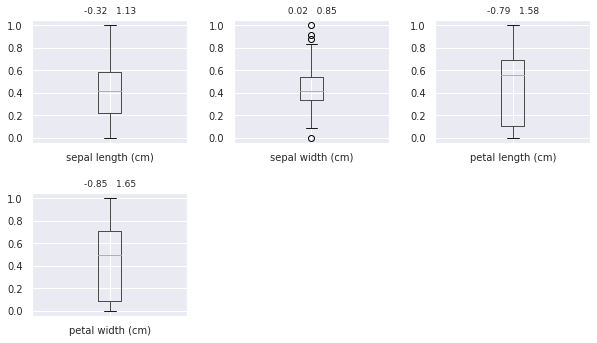

In [155]:
X = pd.DataFrame(X, columns=features)

def func_boxplots(li_st, data_train):
    fig = plt.figure(figsize=(10,15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.rc('axes', titlesize=9)  # размер границ выбросов
    plt.rc('xtick', labelsize=10)  # размер признака
    count = 1
    for i in li_st:
        ax = fig.add_subplot(5, 3, count)
        data_train.boxplot(column=i)
        
        IQR = data_train[i].quantile(0.75) - data_train[i].quantile(0.25)
        lower_bound = data_train[i].quantile(0.25)-1.5*IQR
        upper_bound = data_train[i].quantile(0.75)+1.5*IQR
        plt.title(f'{lower_bound: .2f}  {upper_bound: .2f}')
        
        count += 1

func_boxplots(features, X)

Боксплот показал у признака sepal width наличие трех выбросов.<br>
Посмотрим их

In [156]:
anomalies = X.loc[(X['sepal width (cm)'] > 0.85) | (X['sepal width (cm)'] < 0.02)]
anomalies

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
15,0.388889,1.000000,0.084746,0.125000
32,0.250000,0.875000,0.084746,0.000000
33,0.333333,0.916667,0.067797,0.041667
60,0.194444,0.000000,0.423729,0.375000


Проверим действительно ли эти данные яв-ся выбросами, а не особенностями природы признака.<br>
Для этого попробую предсказать через модель SVC классы для них и сравнить с их реальными классами в переменной target

In [157]:
svc_pred_anom = clf.predict(anomalies)
svc_pred_anom

array([0, 0, 0, 1])

In [158]:
real_anom_class = df.iloc[[15,32,33,60], 4]
real_anom_class = np.array(real_anom_class)
real_anom_class 

array([0, 0, 0, 1])

Видим что значения классов совпадают.<br>
Можем также посмотреть их на графике

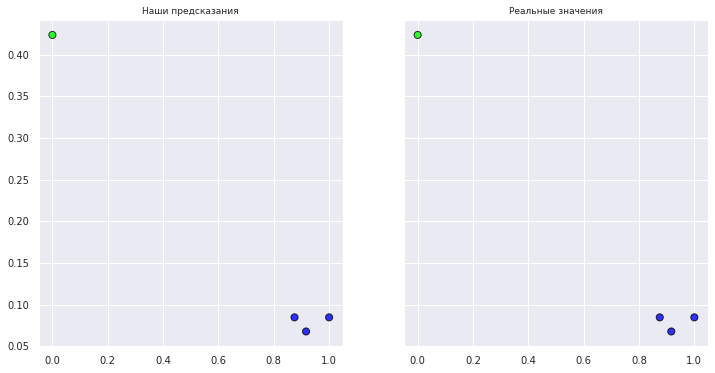

In [159]:
anomalies = np.array(anomalies)
show_differents(real_anom_class, svc_pred_anom, anomalies)

И действительно, без этих данных качество работы модели ухудшается, в чем можно убедиться ниже (было на тесте 0.9556, стало 0.9318):

In [160]:
target = np.delete(target, [15,32,33,60])
X = X.drop([15,32,33,60], axis = 0)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=1)

clf = SVC(gamma="auto", random_state=1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(f' Точность на трейне: {accuracy_score(y_train, y_pred_train): .4f}, на тесте {accuracy_score(y_test, y_pred):.4f}')

 Точность на трейне:  0.9703, на тесте 0.9318


Ниже на матрицу корреляции видим, что наибольшее влияние на тип класса оказывают все признаки ирисов, за исключением sepal widh

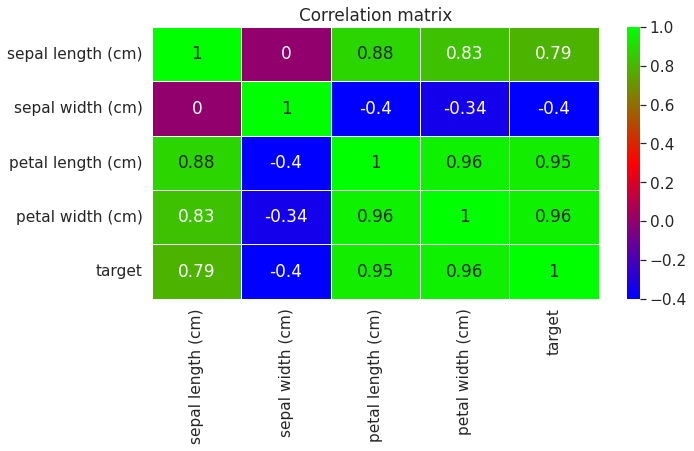

In [162]:
X['target'] = target

plt.figure(figsize=(10, 5))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # это зануляем значения меньше 0,3 считая их слабой связью

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='brg')

plt.title('Correlation matrix')
plt.show()